In [28]:
import pandas as pd         # Pandas for data manipulation
import numpy as np          # Numpy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting
import mne                  # MNE for EEG/MEG data analysis
import os
from mne.preprocessing import ICA

# %matplotlib qt

### Load the .txt file as pandas DataFrame and MNE object

In [29]:
ch_names =  ['FP1', 'FP2', 'C3', 'C4', 'P7', 'P8', 'O1', 'O2', 'photoresistor']

file_path = os.path.join("data", "rec.txt")
use_col = [1,2,3,4,5,6,7,8,14]

rec_df = pd.read_csv(file_path, header=4, index_col=False, usecols=use_col)

rec_df.columns = ch_names

rec_df

,FP1,FP2,C3,C4,P7,P8,O1,O2,photoresistor
0,34867.804929,22572.780856,-187500.022352,44639.205294,47535.164360,54221.554604,45555.783278,67820.311227,0.0
1,35432.968787,23124.041930,-187500.022352,41056.265361,46369.811460,53576.706776,43886.309133,66869.289204,0.0
2,35259.742768,22954.325134,-187500.022352,40842.426222,46556.694395,53860.640986,43837.828200,66864.483579,0.0
3,34675.490519,22387.797819,-187500.022352,44431.155256,47736.553578,54567.939588,45493.019580,67798.451221,0.0
4,34751.732320,22484.804390,-187500.022352,45156.424660,47647.772449,54350.613576,45757.530124,67919.105937,0.0
...,...,...,...,...,...,...,...,...,...
60209,43376.532898,38336.549799,13725.356904,24358.774645,48188.639961,56163.205941,47068.281122,61591.304730,0.0
60210,43609.214557,38597.439360,10876.090631,23273.150417,47285.316561,55550.812847,45924.520007,60956.850464,0.0
60211,43402.326811,38391.356276,11609.943105,24701.583350,47664.491554,55893.174516,46247.010976,61146.192091,0.0
60212,43156.211752,38114.887549,14547.431713,25958.734865,48616.921737,56533.686105,47420.231690,61785.317872,0.0


In [30]:
rec_df_transformed = rec_df.copy()
rec_df_transformed.loc[:, rec_df.columns != "photoresistor"] *= 1e-6
rec_df_transformed = rec_df_transformed.T


ch_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'stim']
info = mne.create_info(ch_names=ch_names, sfreq=250, ch_types=ch_types)

rec_data = rec_df_transformed.to_numpy()
rec_raw = mne.io.RawArray(rec_data, info)
# montage = mne.channels.read_custom_montage('electrode_positions_8channel.sfp')
# rec_raw.set_montage(montage)

Creating RawArray with float64 data, n_channels=9, n_times=60214
    Range : 0 ... 60213 =      0.000 ...   240.852 secs
Ready.


### Create annotations from photoresistor channel

In [31]:
events = mne.find_events(rec_raw, stim_channel="photoresistor")
print(events[:10])
print(events[-1])

95 events found on stim channel photoresistor
Event IDs: [1]
[[   29     0     1]
 [ 1425     0     1]
 [31912     0     1]
 [31936     0     1]
 [31960     0     1]
 [32311     0     1]
 [32611     0     1]
 [32911     0     1]
 [33211     0     1]
 [33512     0     1]]
[59026     0     1]


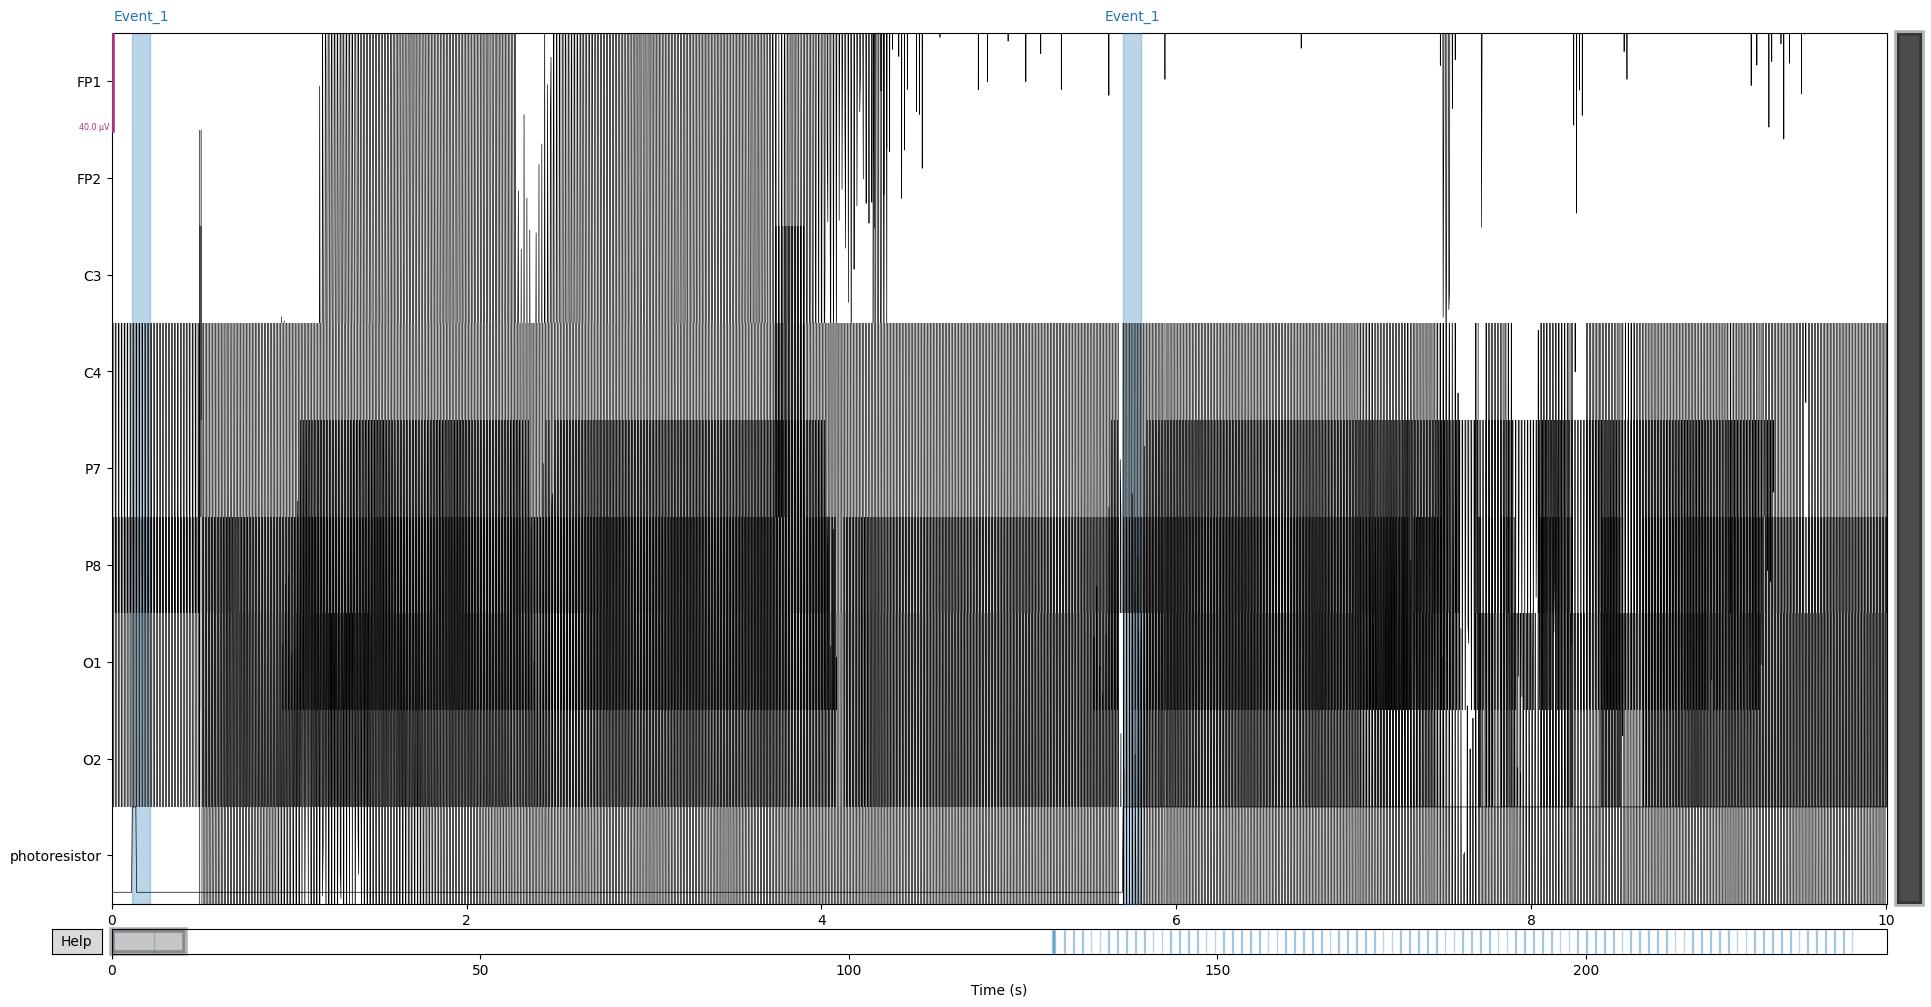

Channels marked as bad:
none


In [33]:
event_onset_times = events[:, 0] / rec_raw.info['sfreq']

event_duration = 0.1

event_descriptions = [f"Event_{event_id}" for event_id in events[:, 2]]

annotations = mne.Annotations(
    onset=event_onset_times,
    duration=[event_duration] * len(event_onset_times),
    description=event_descriptions
)

rec_raw.set_annotations(annotations, emit_warning=True, on_missing='raise', verbose=True)

rec_raw.plot()

### Filter and Visualize

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 825 samples (3.300 s)



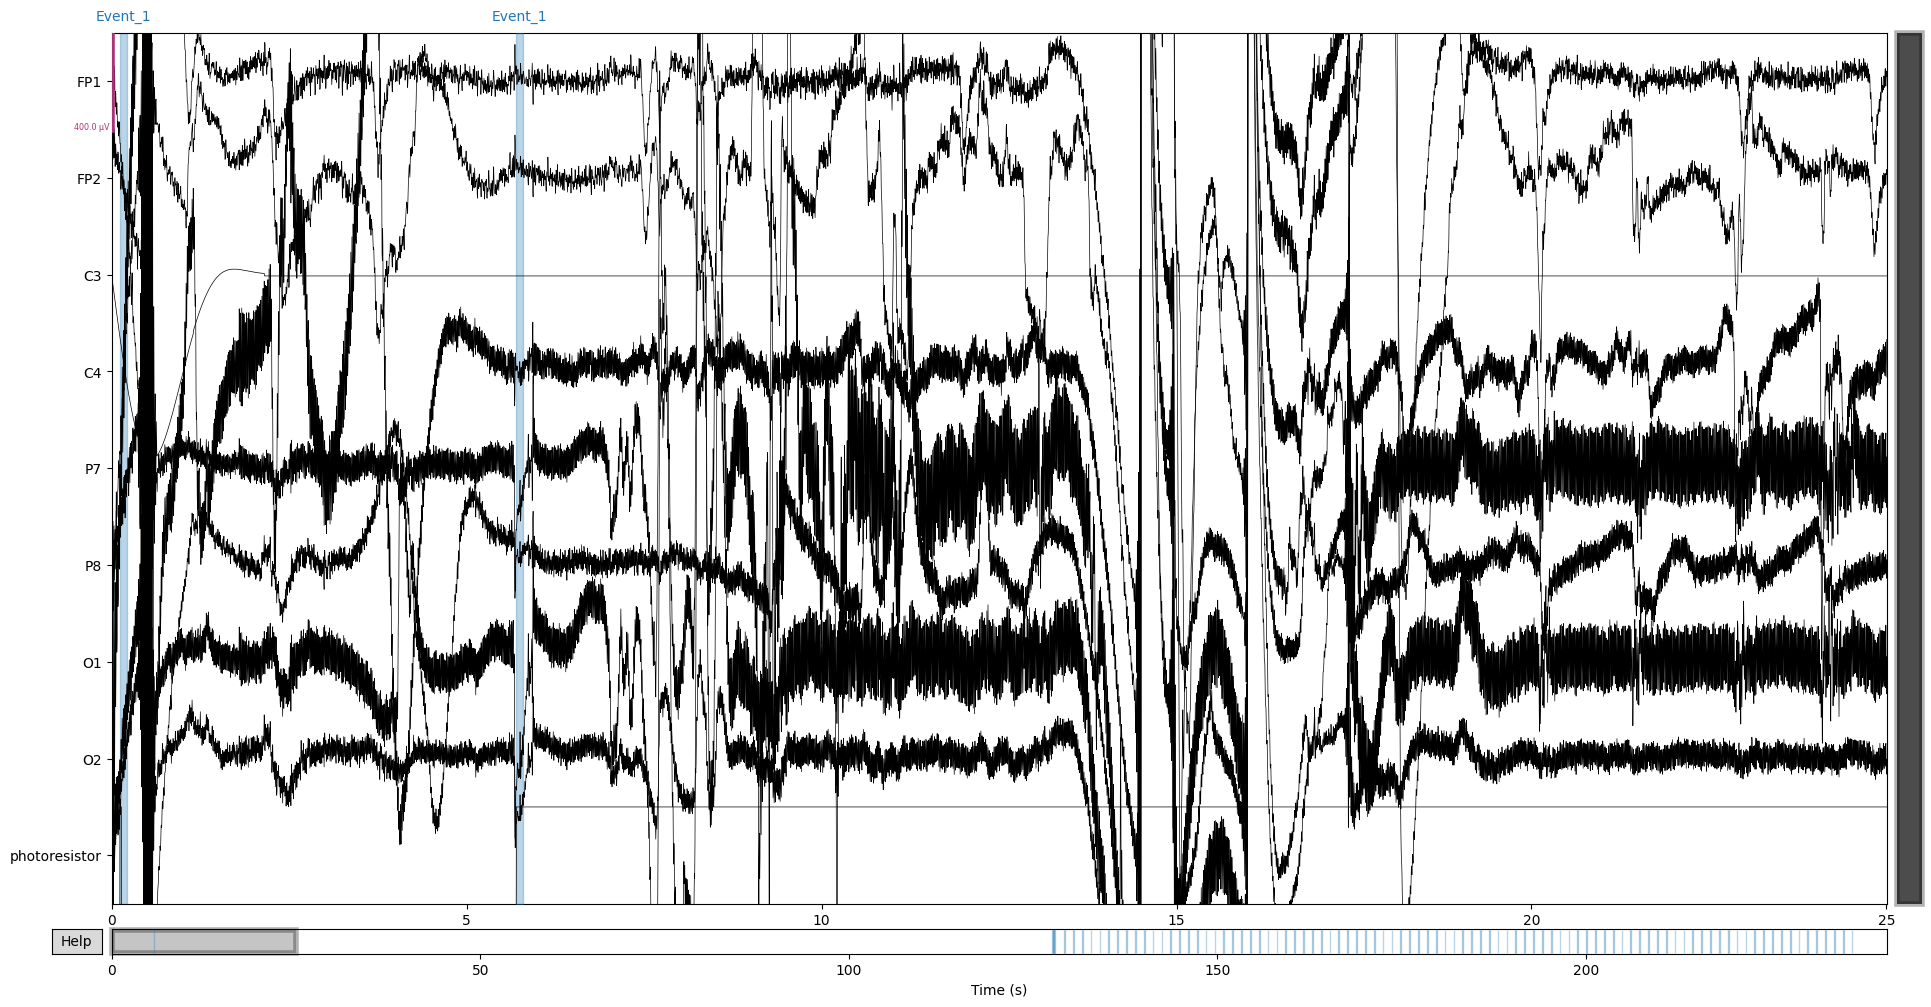

Channels marked as bad:
none


In [34]:
rec_raw.filter(l_freq=1, h_freq=50)
rec_raw.plot(duration=25, scalings=dict(eeg=200e-6), clipping=None)

### Crop and epoch the data

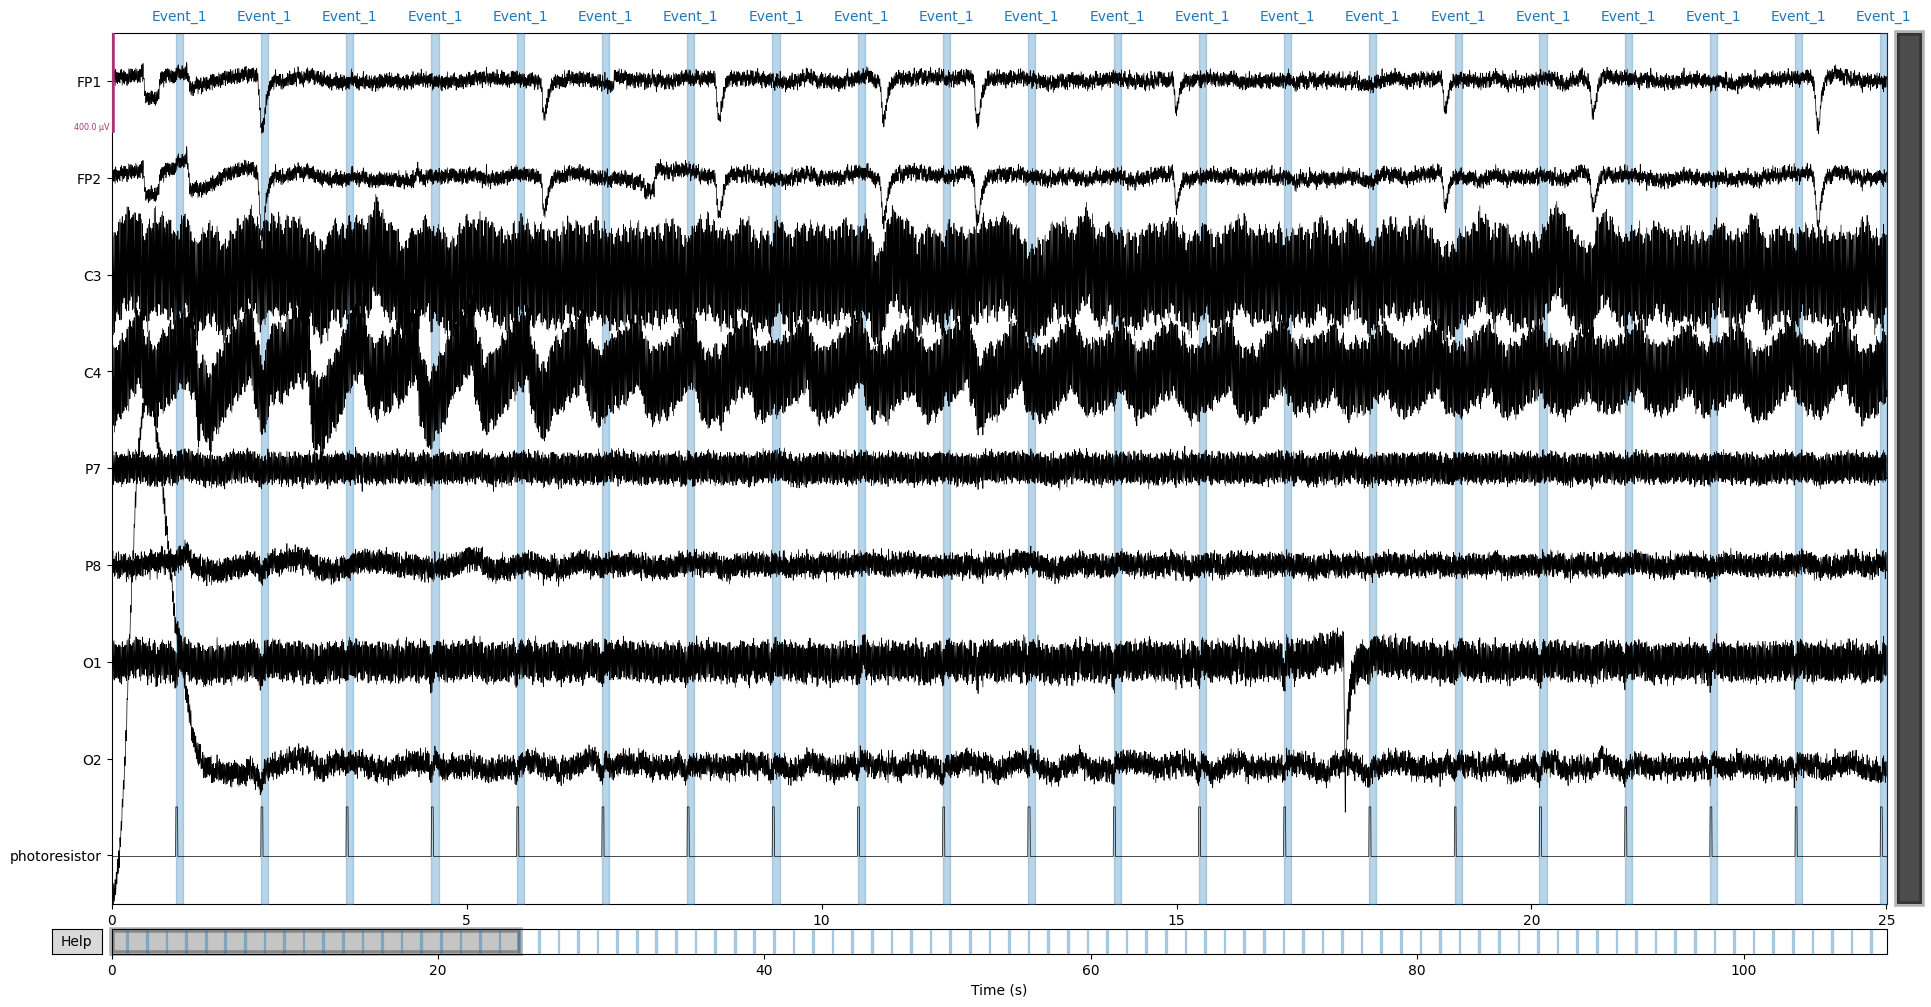

Channels marked as bad:
none


In [35]:
raw_crop = rec_raw.crop(tmin=31960/250+0.5, tmax=59026/250+1, include_tmax=True, verbose=True)
raw_crop.plot(duration=25, scalings=dict(eeg=200e-6), clipping=None)